In [1]:
"""
Ce fichier analyse comment l'evolutin de la position feed d'une valeur assez 
grandre a une valuer tres petite influence la frequence de raisonnance

Dans ce code, On ne touche Ni a la distance meandre ni a la largeur de la piste meandree
"""

"\nCe fichier analyse comment l'evolutin de la position feed d'une valeur assez \ngrandre a une valuer tres petite influence la frequence de raisonnance\n\nDans ce code, On ne touche Ni a la distance meandre ni a la largeur de la piste meandree\n"

In [2]:
from utils.ifa_meander_project_v2.geometry import *
from utils.ifa_meander_project_v2.meshing import *
from utils.ifa_meander_project_v2.frequency import *
from utils.ifa_meander_project_v2.simulation import *

In [3]:
fLow = 700e6
fHigh = 1000e6
fC = 868e6
step = 4e6

frequencies, fc_index, nPoints = generate_frequencies(fLow, fHigh, fC, step)

print(f"Nombre de fréquences (nPoints) : {nPoints}")
print(f"Index de fC : {fc_index}")


Nombre de fréquences (nPoints) : 76
Index de fC : 42


In [4]:
mesh_name = "ifa_meander_anlyse_3.msh"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/ifa_meander_anlyse_3.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [5]:
a = 25 / 1000  # Largeur
b = 45 / 1000  # Hauteur

terminal_a = 55 / 1000
terminal_b = b
x_t = np.array([-terminal_a, 0, 0, -terminal_a])
y_t = np.array([terminal_b, terminal_b, 0, 0])

# On fixe le short feed et la largur de piste
largeur_piste    = 3.767 / 1000
distance_meandre = 4.566 / 1000

mesh_size = 20 / 1000

In [6]:
feed_list = np.linspace(b - 3 * largeur_piste / 2 - 0.5 / 1000, largeur_piste / 2, 50)
print(f"Feed min: {feed_list[-1] * 1000:.2f} mm")
print(f"Feed max: {feed_list[0] * 1000:.2f} mm")

np.save('data/analyse_feed_position/feed_list.npy', feed_list)

Feed min: 1.88 mm
Feed max: 38.85 mm


In [7]:
def creation_ifa(largeur, hauteur, width, dist_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size):
    x, y, N, distance_meandre = ifa_creation(largeur, hauteur, width, dist_meandre)
    x_m, y_m = trace_meander(x, y, width)
    feed_wid = width # La largeur de la piste est la meme partout
    feed_x = np.array([0, distance_meandre, distance_meandre, 0])
    feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed -feed_wid/2, feed - feed_wid/2])
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, mesh_size)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)
    return N, distance_meandre

def plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC=None):
    from matplotlib import pyplot as plt
    frequencies = np.linspace(fLow, fHigh, nPoints)
    frequencies_mhz = np.array(frequencies) / 1e6
    s11_db = np.array(s11_db)

    # Trouver le minimum de S11
    min_index = np.argmin(s11_db)
    f_resonance = frequencies[min_index] / 1e6
    s11_min = s11_db[min_index]

    # Tracé
    fig_size = 7
    Fibonacci = (1 + np.sqrt(5)) / 2
    plt.figure(figsize=(fig_size, fig_size / Fibonacci))
    plt.plot(frequencies_mhz, s11_db, label="S11 (dB)", color='blue')
    plt.plot(f_resonance, s11_min, 'ro', 
            label=f"Résonance: {f_resonance:.2f} MHz (S11={s11_min:.2f} dB)")
    
    if fC:
        fC_mhz = fC / 1e6
        idx_fc = np.argmin(np.abs(frequencies - fC))
        s11_fc = s11_db[idx_fc]
        plt.axvline(fC_mhz, color='green', linestyle='--', 
                   label=f"fC = {fC_mhz:.2f} MHz (S11={s11_fc:.2f} dB)")

    plt.xlabel("Fréquence (MHz)")
    plt.ylabel("S11 (dB)")
    plt.title("Courbe de S11 vs Fréquence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
iteration = 1
frequences_resonance = []
for feed in feed_list:
    try:
        print(f"\n------------------------------------------------------Iteration N°{iteration}------------------------------------------------------")
        print(f"distance meandres {distance_meandre * 1000} mm")
        print(f"Largeur de piste ifa {largeur_piste * 1000} mm")
        print(f"position feed = {feed * 1000} mm\n")
        N_list_elem, new_distance_meandre_elem = creation_ifa(a, b, largeur_piste, distance_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size)
        print(f"Number of meanders {N_list_elem}")
        print(f"New distance meandres {new_distance_meandre_elem * 1000} mm")
        feed_point    = [0, feed, 0]
        frequence_resonance, s11_db = analysis(frequencies, ifa_meander_mat, feed_point)
        frequences_resonance.append(frequence_resonance)
        if frequence_resonance == fC:
            plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)

        iteration += 1
    except ValueError as e:
        print(f"Error: {e}")

np.save(f'data/analyse_feed_position/frequences_resonance.npy', frequences_resonance)


------------------------------------------------------Iteration N°1------------------------------------------------------
distance meandres 4.566 mm
Largeur de piste ifa 3.767 mm
position feed = 38.84949999999999 mm

Number of meanders 3
New distance meandres 4.566333333333334 mm
Simulation 1/76 | f = 700.00 MHz | S11 = -0.29 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.32 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.36 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.40 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.45 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.50 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.56 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.64 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -0.72 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -0.83 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -0.95 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -1.09 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -1.27 dB
Simulation 14/76 | f = 752.00 MHz | S11 = -1.48 dB
Simulation 15

In [9]:
# Charger et afficher la liste largeur_piste_list.npy
loaded_feed_list = np.load('data/analyse_feed_position/feed_list.npy')
print("\nContenu de loaded_largeur_piste_list.npy :", loaded_feed_list / b * 100)

# Charger et afficher la liste N_list.npy
loaded_frequences_resonance = np.load('data/analyse_feed_position/frequences_resonance.npy')
print("\nContenu de frequences_resonance.npy :", loaded_frequences_resonance * 1e-6)


Contenu de loaded_largeur_piste_list.npy : [86.33222222 84.65575964 82.97929705 81.30283447 79.62637188 77.9499093
 76.27344671 74.59698413 72.92052154 71.24405896 69.56759637 67.89113379
 66.2146712  64.53820862 62.86174603 61.18528345 59.50882086 57.83235828
 56.15589569 54.47943311 52.80297052 51.12650794 49.45004535 47.77358277
 46.09712018 44.4206576  42.74419501 41.06773243 39.39126984 37.71480726
 36.03834467 34.36188209 32.6854195  31.00895692 29.33249433 27.65603175
 25.97956916 24.30310658 22.62664399 20.95018141 19.27371882 17.59725624
 15.92079365 14.24433107 12.56786848 10.8914059   9.21494331  7.53848073
  5.86201814  4.18555556]

Contenu de frequences_resonance.npy : [800. 804. 820. 824. 828. 832. 836. 836. 840. 840. 844. 844. 844. 844.
 848. 848. 852. 852. 856. 864. 864. 872. 872. 892. 892. 896. 896. 900.
 904. 904. 904. 904. 908. 908. 908. 908. 916. 916. 916. 920. 920. 924.
 928. 928. 932. 932. 932. 936. 936. 928.]


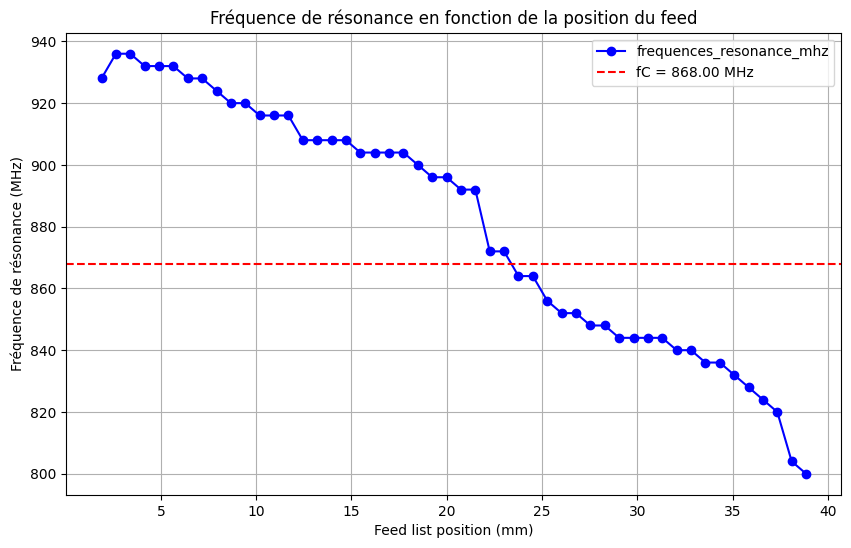

In [10]:
from matplotlib import pyplot as plt

# Conversion des données
frequences_resonance_mhz = np.array(loaded_frequences_resonance) * 1e-6
loaded_feed_list_mm = np.array(loaded_feed_list) * 1000  # Conversion en mm

plt.figure(figsize=(10, 6))
plt.plot(loaded_feed_list_mm, frequences_resonance_mhz, marker='o', linestyle='-', color='b', label='frequences_resonance_mhz')

# Ajouter une ligne horizontale pour fC
plt.axhline(y=fC * 1e-6, color='r', linestyle='--', label=f'fC = {fC * 1e-6:.2f} MHz')

plt.xlabel('Feed list position (mm)')
plt.ylabel('Fréquence de résonance (MHz)')
plt.title('Fréquence de résonance en fonction de la position du feed')
plt.legend()
plt.grid(True)
plt.show()